# Voxel-level Simulations
This notebook simulates a single fibre and crossing fibre voxel-level configuration to validate LoRE-SD. Every configuration will be tested at multiple signal-to-noise ratios (SNR) to evaluate the robustness of the method.

Some of this code makes use of the MRtrix3 software. Please make sure to have it installed and available in your PATH.

In [1]:
import os

# We use MRtrix3 for some of the preprocessing steps (e.g. dwi2response and dwi2fod)
# Add the MRtrix3 binary directory to the PATH
mrtrix_bin_dir = '/SOFTWARE/mrtrix3/bin'  # Replace with the actual path to MRtrix3 binaries
os.environ['PATH'] += os.pathsep + mrtrix_bin_dir

In [2]:
import sys
sys.path.insert(0, '../')

In [3]:
import subprocess

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lore_sd.utils import gradient_utils, math_utils, plot_utils
from lore_sd.utils import SphericalHarmonics as sh

from lore_sd.simulation import simulation
from lore_sd.optimisation import optimise
from lore_sd.mrtrix_io.io import load_mrtrix, save_mrtrix
from lore_sd.mrtrix_io.io.image import Image

## Constants

In [4]:
lmax = 8

bvals = np.array([0, 1000, 2000])

grad = gradient_utils.create_gradient_table(bvals, [2, 128, 128])

# Calculate the transformation matrix to map SH coefficients to spherical coordinates
# Required for ODF non-negativity
Q = optimise.get_transformation_matrix(300, lmax)

dirgen: [done] Optimising directions up to power 1 (10 restarts)[0K
dirgen: final energy = 1.4142135623730949
dirgen: [done] Optimising directions up to power 1 (10 restarts)[0K
dirgen: final energy = 15221.824005145003
dirgen: [done] Optimising directions up to power 1 (10 restarts)[0K
dirgen: final energy = 15221.82290867486
dirgen: [done] Optimising directions up to power 1 (10 restarts)[0K
dirgen: final energy = 85867.195779796573


In [5]:
# LoRE-SD Parameters
reg = 1e-3

axial_diffusivities = np.linspace(0, 4e-3, 10)
radial_diffusivities = np.linspace(0, 4e-3, 10)

# Gaussian basis functions used in LoRE-SD representation
gaussians = optimise.get_gaussians(axial_diffusivities, radial_diffusivities, bvals, lmax)

## Simulated Configurations

ODFs are simulated using single-fibre, 60° crossing-fibre and bending fibre configurations (10 uniformly spread ODFs over 120°). The parameters used for the response functions are as follows:

| **Parameter**       | **Response Function** | **Alternative Response Function** |
|---------------------|-----------------------|-----------------------------------|
| $f_{stick}$         | 0.45                  | 0.3                               |
| $f_{zeppelin}$      | 0.45                  | 0.4                               |
| $f_{water}$         | 0.1                   | 0.3                               |
| $D_a^\parallel$     | $2.2\;\mu m^2/ms$     | $2.2\;\mu m^2/ms$                 |
| $D_e^\parallel$     | $2.0\;\mu m^2/ms$     | $2.0\;\mu m^2/ms$                 |
| $D_e^\perp$         | $0.7\;\mu m^2/ms$     | $1.4\;\mu m^2/ms$                 |

In [6]:
# Single Fibre ODF
single_fibre = simulation.getOrientedApodizedDirac(0, 0, lmax).flatten()
single_fibre_60 = simulation.getOrientedApodizedDirac(60, 0, lmax).flatten()
# Crossing Fibre ODF at 60 degrees
crossing_60 = .5*single_fibre + .5*single_fibre_60

In [7]:
# Bending ODF
theta_bend = np.linspace(30, 150, 10)
phi_bend = np.zeros_like(theta_bend)

bending_odf = (np.sum([simulation.getOrientedApodizedDirac(t, p, lmax) for (t, p) in zip(theta_bend, phi_bend)], axis=0) / len(theta_bend)).flatten()

In [8]:
stick = sh.zhgaussian(bvals, 2.2e-3, 0)
zeppelin = sh.zhgaussian(bvals, 2e-3, .7e-3)
water = sh.zhgaussian(bvals, 3e-3, 3e-3)

sane_rf = .45*stick + .45*zeppelin + .1*water
alternative_rf = .3*stick + .4*sh.zhgaussian(bvals, 2e-3, 1.4e-3) + .3*water

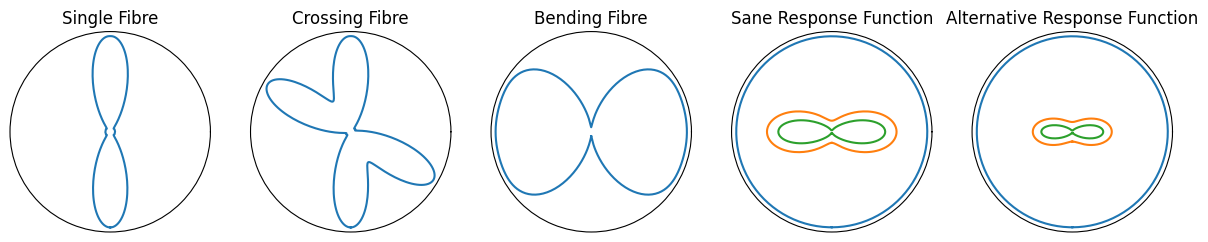

In [ ]:
response_functions = [sane_rf, alternative_rf]
titles = ['Sane Response Function', 'Alternative Response Function']

fig = plt.figure(figsize=(15,3))
gridspec = fig.add_gridspec(nrows=1, ncols=3 + len(response_functions))
ax_single_fibre = fig.add_subplot(gridspec[0, 0], projection='polar')
ax_crossing_fibre = fig.add_subplot(gridspec[0, 1], projection='polar')
ax_bending_fibre = fig.add_subplot(gridspec[0, 2], projection='polar')

sh.plot_odf_on_axis(single_fibre, ax=ax_single_fibre)
sh.plot_odf_on_axis(crossing_60, ax=ax_crossing_fibre)
sh.plot_odf_on_axis(bending_odf, ax=ax_bending_fibre)

ax_single_fibre.set_title('Single Fibre')
ax_crossing_fibre.set_title(r'Crossing Fibre')
ax_bending_fibre.set_title(r'Bending Fibre')

for i, (rf, title) in enumerate(zip(response_functions, titles)):
    ax = fig.add_subplot(gridspec[0, 3 + i], projection='polar')
    sh.plot_wmr_on_axis(rf, bvals, ax=ax, c='blue')
    ax.set_title(title)

plt.show()

## Simulation Functions
Functions to simulate a single voxel with a given fibre configuration and SNR. The function `add_noise` adds Rician noise to the signal. The function `run_msst_csd` estimates the ODF using MSMT-CSD. The function `run_simulation` simulates the voxel and estimates the ODF using LoRE-SD and MSMT-CSD.

In [10]:
def add_noise(noise_free, grad, snr):
    """
    Add Gaussian noise or Rician noise to a signal.

    Returns:
        numpy.ndarray: A signal with added Gaussian/Rician noise.
    """

    mean_b0 = np.mean(noise_free[..., np.where(grad[...,-1] == 0)[0]])

    std_noise = mean_b0 / snr
    noise1 = np.random.normal(0, std_noise, size=noise_free.shape)
    noise2 = np.random.normal(0, std_noise, size=noise_free.shape)
    noisy_dwi = np.sqrt((noise_free + noise1)**2 + noise2**2)

    return noisy_dwi

In [11]:
def run_msmt_csd(dwi, mask, grad, rf, cores=None):
    # Create a temporary directory for the output
    tmp_dir = os.path.join(os.getcwd(), f'tmp_{os.getpid()}')
    os.makedirs(tmp_dir, exist_ok=True)

    dwi_path = os.path.join(tmp_dir, 'dwi.mif')
    mask_path = os.path.join(tmp_dir, 'mask.mif')
    rf_path = os.path.join(tmp_dir, 'rf.mif')
    odf_path = os.path.join(tmp_dir, 'odf.mif')

    save_mrtrix(dwi_path, Image(dwi, grad=grad, comments=''))
    save_mrtrix(mask_path, Image(mask.astype(np.uint8)))
    np.savetxt(rf_path, rf)

    csd_cmd = f'dwi2fod msmt_csd {dwi_path} {rf_path} {odf_path} -mask {mask_path} -nthreads {cores} -force -quiet'
    subprocess.run(csd_cmd, shell=True)
    odf = load_mrtrix(odf_path).data

    # Clean up temporary files
    for path in [dwi_path, mask_path, rf_path, odf_path]:
        os.remove(path)
    os.rmdir(tmp_dir)
    return odf

def run_lore_sd(dwi, mask, grad, Q, lmax, cores=50):
    result = optimise.get_signal_decomposition(dwi, mask, grad, np.linspace(0, 4e-3, 10), np.linspace(0, 4e-3, 10), 1e-3, Q, lmax, cores)
    return result['odf']


### Simulation Variables

In [12]:
snrs = [10, 20, 50, np.inf]

In [13]:
num_x, num_y, num_z = 5, 10, 10
num_its_simulation = num_x * num_y * num_z

voxel_dict = {
    'single_fibre_voxel': sh.calcdwi(sh.sphconv(sane_rf, single_fibre), grad),
    'crossing_60_voxel': sh.calcdwi(sh.sphconv(sane_rf, crossing_60), grad),
    'bending_odf_voxel': sh.calcdwi(sh.sphconv(sane_rf, bending_odf), grad),
    'alternative_rf_voxel': .5 * sh.calcdwi(sh.sphconv(alternative_rf, single_fibre), grad) + .5 * sh.calcdwi(sh.sphconv(alternative_rf, single_fibre_60), grad),
}

# Reshape the data for each voxel type
simulation_dict = {}
for key in voxel_dict.keys():
    simulation_dict[key.replace('_voxel', '_dwi')] = np.repeat(voxel_dict[key][np.newaxis,...], num_its_simulation, axis=0).reshape((num_x, num_y, num_z, -1))


In [14]:
# Since this is a simulation, all voxels belong to the mask
mask = np.ones((num_x, num_y, num_z), dtype=bool)

# Simulations

In [15]:
# total = len(snrs) * len(dwi_dict)
# count = 0
# median_rf_lore_dispersed = []
# median_rf_lore_bending = []
# median_odf_lore_dispersed = []
# median_odf_lore_bending = []
# median_odf_smt_dispersed = []
# median_odf_smt_bending = []

# for snr in np.flip(snrs):
#     for fibre_config, noise_free_dwi in dwi_dict.items():
#         count += 1
#         print(f'{count}/{total}')
#         if 'dwi' not in fibre_config:
#             continue
#         noisy_dwi = add_noise(noise_free_dwi, grad, snr)

#         save_mrtrix(os.path.join(SAVE_DIR, f'{fibre_config}_{snr}.mif'), Image(noisy_dwi, grad=grad))
#         mask = np.ones_like(noisy_dwi[...,0], dtype=float)
#         save_mrtrix(os.path.join(SAVE_DIR, f'mask.mif'), Image(mask))
#         dwi = load_mrtrix(os.path.join(SAVE_DIR, f'{fibre_config}_{snr}.mif')).data
#         grad = load_mrtrix(os.path.join(SAVE_DIR, f'{fibre_config}_{snr}.mif')).grad
#         mask = load_mrtrix(os.path.join(SAVE_DIR, 'mask.mif')).data > .5

#         if 'double_zeppelin' in fibre_config:
#             np.savetxt(os.path.join(SAVE_DIR, 'response.txt'), double_zeppelin)
#         else:
#             np.savetxt(os.path.join(SAVE_DIR, 'response.txt'), sane_rf)

#         result = run_lore_sd(dwi, mask.astype(bool), grad, Q, lmax, cores=50)
#         save_mrtrix(os.path.join(SAVE_DIR, f'{fibre_config}_{snr}_lore_odf.mif'), Image(result['odf']))
#         save_mrtrix(os.path.join(SAVE_DIR, f'{fibre_config}_{snr}_lore_gf.mif'), Image(result['gaussian_fractions']))
#         save_mrtrix(os.path.join(SAVE_DIR, f'{fibre_config}_{snr}_lore_pred.mif'), Image(result['predicted_signal'], grad=grad))
    
#         run_msmt_csd(os.path.join(SAVE_DIR, f'{fibre_config}_{snr}.mif'), os.path.join(SAVE_DIR, f'mask.mif'), os.path.join(SAVE_DIR, 'response.txt'), os.path.join(SAVE_DIR, f'{fibre_config}_{snr}_msmt_odf.mif'), os.path.join(SAVE_DIR, f'{fibre_config}_{snr}_msmt_pred.mif'))
        
#         # odf_smt, recon_smt = run_mcsmt(dwi, grad, grad, mask.astype(bool), cores=50)
#         # save_mrtrix(os.path.join(SAVE_DIR, f'{fibre_config}_{snr}_smt_odf.mif'), Image(odf_smt))
#         # save_mrtrix(os.path.join(SAVE_DIR, f'{fibre_config}_{snr}_smt_pred.mif'), Image(recon_smt, grad=grad))

In [16]:
from matplotlib.pyplot import setp

# function for setting the colors of the box plots pairs
def setBoxColors(bp):
    setp(bp['boxes'][0], color='blue')
    setp(bp['caps'][0], color='blue')
    setp(bp['caps'][1], color='blue')
    setp(bp['whiskers'][0], color='blue')
    setp(bp['whiskers'][1], color='blue')
    setp(bp['medians'][0], color='blue')

    setp(bp['boxes'][1], color='orange')
    setp(bp['caps'][2], color='orange')
    setp(bp['caps'][3], color='orange')
    setp(bp['whiskers'][2], color='orange')
    setp(bp['whiskers'][3], color='orange')
    setp(bp['medians'][1], color='orange')

In [ ]:
# Boxplots of the angular correlation coefficients
fig = plt.figure(figsize=(15, 5))  # Adjusted height for two rows
gs = fig.add_gridspec(2, 8, wspace=0.5, hspace=.7)
snr_strings = np.flip(['10', '20', '50', r'$\infty$'])
methods = ['lore', 'msmt']
method_labels = ['LoRE-SD', 'MSMT-CSD']
colors = ['blue', 'orange']

for col_idx, (fibre_config, noise_free_dwi) in list(enumerate(simulation_dict.items())):
        print(col_idx)
        ax_odf = fig.add_subplot(gs[0, 2 * col_idx], projection='polar')
        ax_rf = fig.add_subplot(gs[0, 2 * col_idx + 1], projection='polar')

        ax_boxplot = fig.add_subplot(gs[1, 2 * col_idx:2 * col_idx + 2])
        for i, snr in enumerate(np.flip(snrs)):

            dwi = add_noise(noise_free_dwi, grad, snr)
            rf = alternative_rf if 'alternative_rf' in fibre_config else sane_rf

            odf_msmt_csd = run_msmt_csd(dwi, mask, grad, rf, cores=50)
            odf_lore_sd = run_lore_sd(dwi, mask, grad, Q, lmax, cores=50)
            
            gt_rf = alternative_rf if 'alternative_rf' in fibre_config else sane_rf

            if 'single' in fibre_config:
                gt_odf = single_fibre
            elif 'bending' in fibre_config:
                gt_odf = bending_odf
            else:
                gt_odf = crossing_60

            sh.plot_odf_on_axis(gt_odf, ax=ax_odf, c='blue')
            sh.plot_wmr_on_axis(gt_rf, bvals, ax=ax_rf, c='blue')

            accs = [sh.angularCorrelation(odf, gt_odf)[mask] for odf in [odf_lore_sd, odf_msmt_csd]]

            bp = ax_boxplot.boxplot(
                accs,
                positions=[1 + 3 * i + j * 0.5 for j in range(len(methods))],
                widths=0.4,
                showfliers=False
            )
            setBoxColors(bp)
            ax_boxplot.set_xticks([1.5 + 3 * i for i in range(len(snrs))])
            ax_boxplot.set_xticklabels(snr_strings, fontsize=12)
            ax_boxplot.set_xlabel('SNR')
            ax_boxplot.set_yticks([.7, .8, .9, 1])
            ax_boxplot.set_ylim([.7, 1])

            if col_idx != 0:
                ax_boxplot.set_yticklabels([])
            else:
                ax_boxplot.set_yticklabels([.7, .8, .9, 1], fontsize=12)

            if fibre_config == 'single_fibre_dwi':
                title = 'Single Fibre'
            elif fibre_config == 'crossing_60_dwi':
                title = 'Crossing Fibre'
            elif fibre_config == 'imbalanced_odf_dwi':
                title = 'Imbalanced Crossing Fibre'
            elif fibre_config == 'alternative_rf_dwi':
                title = 'Alternative Response Function'
            elif fibre_config == 'bending_odf_dwi':
                title = 'Bending Fibre'

            ax_boxplot.set_title(title, fontsize=16, y=2.7)

            if (col_idx == 0):
                ax_odf.set_ylabel('Simulated ODF & RF', fontsize=12, labelpad=30)
                ax_boxplot.set_ylabel('ODF ACC', fontsize=12)

# Draw temporary lines and use them to create a legend
handles = [ax_boxplot.plot([], [], '-', color=color, label=label)[0] for color, label in zip(colors, method_labels)]
fig.legend(handles, method_labels, fontsize=12, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=len(method_labels), frameon=True)
plt.savefig('/LOCALDATA/sleyse4/LoRE-SD_Review/odf_rf_boxplots_with_disp.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

0


100%|██████████| 500/500 [00:03<00:00, 154.98it/s]


Execution time: 00h 00m 03s


100%|██████████| 500/500 [00:03<00:00, 163.60it/s]


Execution time: 00h 00m 03s


100%|██████████| 500/500 [00:02<00:00, 172.36it/s]


Execution time: 00h 00m 03s


100%|██████████| 500/500 [00:03<00:00, 156.89it/s]


Execution time: 00h 00m 03s
1


100%|██████████| 500/500 [00:03<00:00, 141.73it/s]


Execution time: 00h 00m 04s


100%|██████████| 500/500 [00:03<00:00, 142.37it/s]


Execution time: 00h 00m 04s


100%|██████████| 500/500 [00:03<00:00, 145.27it/s]


In [ ]:
raise Exception